In [9]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline


df = pd.read_csv(r"C:\Users\HP\Downloads\crimedatasetcsv.csv")
df = df[pd.notnull(df['tags'])]
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

                                                post          tags
0  I  have received a message that I have won a l...  lottery scam
1  I got an email that I won a lottery is it a scam?  lottery scam
2   I got a  call from unknown number and have wo...  lottery scam
3    I have deposited money to get the lottery money  lottery scam
4                     how can I report lottery fraud  lottery scam
5               how can I file FIR for lottery fraud  lottery scam
6  I have transferred money to claim prize money ...  lottery scam
7   how to make a complaint for online lottery fraud  lottery scam
8  I have paid processing charges for lottery how...  lottery scam
9  I have paid transfer charges for lottery how c...  lottery scam
754


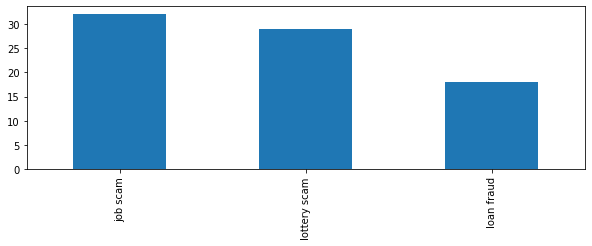

In [26]:
my_tags = ['lottery scam','loan fraud','job scam']
plt.figure(figsize=(10,3))
df.tags.value_counts().plot(kind='bar');

In [14]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(2)

 I got a  call from unknown number and have won a prize in a lottery 
Tag: lottery scam


In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)
print_plot(10)

got message saying prize
Tag: lottery scam


In [16]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.75
              precision    recall  f1-score   support

lottery scam       0.67      0.89      0.76         9
  loan fraud       1.00      0.17      0.29         6
    job scam       0.82      1.00      0.90         9

   micro avg       0.75      0.75      0.75        24
   macro avg       0.83      0.69      0.65        24
weighted avg       0.81      0.75      0.69        24



In [19]:

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.875
              precision    recall  f1-score   support

lottery scam       0.75      1.00      0.86         9
  loan fraud       1.00      0.67      0.80         6
    job scam       1.00      0.89      0.94         9

   micro avg       0.88      0.88      0.88        24
   macro avg       0.92      0.85      0.87        24
weighted avg       0.91      0.88      0.87        24



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [21]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9583333333333334
              precision    recall  f1-score   support

lottery scam       0.90      1.00      0.95         9
  loan fraud       1.00      0.83      0.91         6
    job scam       1.00      1.00      1.00         9

   micro avg       0.96      0.96      0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("f:\GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [28]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [29]:

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [39]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [47]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim 
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

C:\Users\HP\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [26]:
all_data[:2]

[TaggedDocument(words=['full-text', 'search', 'with', 'php', 'and', 'pdo', 'not', 'returning', 'any', 'result', 'i', 've', 'searched', 'a', 'lot', 'on', 'this', 'matter', 'but', 'i', 'can', 't', 'find', 'out', 'what', 's', 'wrong', 'with', 'my', 'setup.', 'i', 'm', 'trying', 'to', 'do', 'a', 'full-text', 'search', 'using', 'pdo', 'and', 'php', 'but', 'i', 'don', 't', 'get', 'any', 'results', 'or', 'error', 'messages', 'at', 'all.', 'my', 'table', 'contains', 'customer', 'details:', '<pre><code>id', 'int(11)', 'auto_increment', 'name', 'varchar(150)', 'lastname', 'varchar(150)', 'company', 'varchar(250)', 'adress', 'varchar(150)', 'postcode', 'int(5)', 'city', 'varchar(150)', 'email', 'varchar(250)', 'phone', 'varchar(20)', 'orgnr', 'varchar(15)', 'timestamp', 'timestamp', 'current_timestamp', '</code></pre>', 'i', 'did', 'run', 'the', 'sql-query:', '<pre><code>alter', 'table', 'system_customer', 'add', 'fulltext(name', 'lastname', '...', '...)', '</code></pre>', 'except', 'for', 'the',

In [45]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple

In [48]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79137.81it/s]


In [52]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: bad input shape (55, 3)

In [50]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 49 samples, validate on 6 samples
Epoch 1/2
49/49 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.34 - 0s 3ms/step - loss: 1.1077 - accuracy: 0.3469 - val_loss: 1.1286 - val_accuracy: 0.0000e+00
Epoch 2/2
49/49 [==============================] - ETA: 0s - loss: 1.0559 - accuracy: 0.53 - 0s 611us/step - loss: 1.0439 - accuracy: 0.6327 - val_loss: 1.1653 - val_accuracy: 0.0000e+00


In [51]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

24/24 [==============================] - 0s 83us/step
Test accuracy: 0.0
